In [17]:
import tensorflow.keras.layers
import tensorflow.keras.models
import matplotlib.pyplot as plt
import tensorflow.keras.datasets
import tensorflow.keras.optimizers 
from os import walk
import numpy
from timeit import default_timer as timer
from keras.preprocessing.image import load_img 
import warnings 
from keras.preprocessing.image import img_to_array 
from keras.preprocessing.image import array_to_img 

In [3]:
def get_size(np):
    return np.size * np.itemsize

In [ ]:
### Loading manga images in the memory
IMAGE_PATH = "./mangas/"
images = []
for (dirpath, dirnames, filenames) in walk(IMAGE_PATH):
    images.extend(filenames)
    break

mangas = []
for img in images:
    img_path = f"{IMAGE_PATH}{img}"
    img_data = load_img(img_path)
    mangas.append(img_to_array(img_data))

In [23]:
print(len(f))


30995


In [3]:
x = tensorflow.keras.layers.Input(shape=(784), name="encoder_input")

encoder_dense_layer1 = tensorflow.keras.layers.Dense(units=300, name="encoder_dense_1")(x)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_dense_layer1)

encoder_dense_layer2 = tensorflow.keras.layers.Dense(units=8, name="encoder_dense_2")(encoder_activ_layer1)
encoder_output = tensorflow.keras.layers.LeakyReLU(name="encoder_output")(encoder_dense_layer2)

encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
decoder_input = tensorflow.keras.layers.Input(shape=(8), name="decoder_input")

decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=300, name="decoder_dense_1")(decoder_input)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_dense_layer1)

decoder_dense_layer2 = tensorflow.keras.layers.Dense(units=784, name="decoder_dense_2")(decoder_activ_layer1)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_dense_layer2)

decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")

In [8]:
ae_input = tensorflow.keras.layers.Input(shape=(784), name="AE_input")
ae_encoder_output = encoder(ae_input)
ae_decoder_output = decoder(ae_encoder_output)

ae = tensorflow.keras.models.Model(ae_input, ae_decoder_output, name="AE")
ae.compile(loss="mse", optimizer=tensorflow.keras.optimizers.Adam(lr=0.0005))

In [10]:
(x_train_orig, y_train), (x_test_orig, y_test) = tensorflow.keras.datasets.mnist.load_data()
x_train_orig = x_train_orig.astype("float32") / 255.0
x_test_orig = x_test_orig.astype("float32") / 255.0

x_train = numpy.reshape(x_train_orig, newshape=(x_train_orig.shape[0], numpy.prod(x_train_orig.shape[1:])))
x_test = numpy.reshape(x_test_orig, newshape=(x_test_orig.shape[0], numpy.prod(x_test_orig.shape[1:])))

In [9]:
ae.fit(x_train, x_train, epochs=120, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/120
60000/60000 [==============================] - 98s 2ms/sample - loss: 0.0446 - val_loss: 0.0336
Epoch 2/120
60000/60000 [==============================] - 1s 18us/sample - loss: 0.0318 - val_loss: 0.0296
Epoch 3/120
60000/60000 [==============================] - 1s 18us/sample - loss: 0.0289 - val_loss: 0.0278
Epoch 4/120
60000/60000 [==============================] - 1s 18us/sample - loss: 0.0275 - val_loss: 0.0267
Epoch 5/120
60000/60000 [==============================] - 1s 18us/sample - loss: 0.0266 - val_loss: 0.0260
Epoch 6/120
60000/60000 [==============================] - 1s 18us/sample - loss: 0.0260 - val_loss: 0.0254
Epoch 7/120
60000/60000 [==============================] - 1s 18us/sample - loss: 0.0254 - val_loss: 0.0250
Epoch 8/120
60000/60000 [==============================] - 1s 18us/sample - loss: 0.0249 - val_loss: 0.0245
Epoch 9/120
60000/60000 [==============================] - 1s 18us/sample - loss: 0.02

Epoch 76/120
60000/60000 [==============================] - 1s 18us/sample - loss: 0.0195 - val_loss: 0.0197
Epoch 77/120
60000/60000 [==============================] - 1s 18us/sample - loss: 0.0195 - val_loss: 0.0196
Epoch 78/120
60000/60000 [==============================] - 1s 18us/sample - loss: 0.0194 - val_loss: 0.0197
Epoch 79/120
60000/60000 [==============================] - 1s 18us/sample - loss: 0.0194 - val_loss: 0.0196
Epoch 80/120
60000/60000 [==============================] - 1s 18us/sample - loss: 0.0194 - val_loss: 0.0196
Epoch 81/120
60000/60000 [==============================] - 1s 18us/sample - loss: 0.0194 - val_loss: 0.0196
Epoch 82/120
60000/60000 [==============================] - 1s 18us/sample - loss: 0.0193 - val_loss: 0.0196
Epoch 83/120
60000/60000 [==============================] - 1s 18us/sample - loss: 0.0194 - val_loss: 0.0196
Epoch 84/120
60000/60000 [==============================] - 1s 18us/sample - loss: 0.0193 - val_loss: 0.0196
Epoch 85/120
60000/

In [10]:
encoded_images = encoder.predict(x_train)
decoded_images = decoder.predict(encoded_images)

decoded_images_orig = numpy.reshape(decoded_images, newshape=(decoded_images.shape[0], 28, 28))

In [17]:
def plot_image(random_number):
    num_images_to_show = 1
    plt.subplot(num_images_to_show, 2, 1)
    plt.imshow(x_train_orig[random_number, :, :], cmap="gray")
    plt.subplot(num_images_to_show, 2, 2)
    plt.imshow(decoded_images_orig[random_number, :, :], cmap="gray")
    print(f"Original =>{get_size(x_train_orig[random_number, :, :])}")
    print(f"Encoded =>{get_size(encoded_images[random_number])}")

In [16]:
def generate_image(encoded_image):
    num_images_to_show = 1
    start = timer()
    decoded_image = decoder.predict([encoded_image])
    decoded_image_orig = numpy.reshape(decoded_image, newshape=(decoded_image.shape[0], 28, 28))
    plt.subplot(num_images_to_show, 2, 1)
    plt.imshow(decoded_image_orig[0, :, :], cmap="gray")
    end = timer()
    print(f"Time taken to decompress => {end - start} secs")

Original =>3136
Encoded =>32


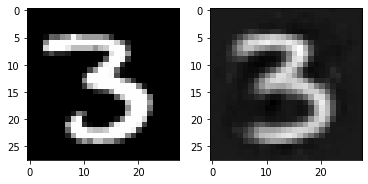

In [18]:
plot_image(12)

Time taken to decompress => 0.02045366000015747 secs


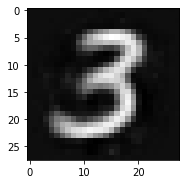

In [19]:
generate_image([encoded_images[215]])

In [22]:
ae.save("models/mnist-numbers")